In [18]:
import pandas as pd
import wikipediaapi
import os
from SPARQLWrapper import SPARQLWrapper, JSON
import json
from sklearn.datasets import load_files
import numpy as np
from sklearn.utils import shuffle
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

## DATA COLLECTION ##########################################################################

In [2]:
def collectBiographiesFromCategories(categorymembers, category, data, number_people, level=0, max_level=1): 
    """
    Recursively collects biographical texts and fact graphs for each person in specified Wikipedia category members up to a given recursion level.

    Parameters:
        categorymembers (dict): A dictionary of category member pages from the WikipediaAPI.
        category (str): The name of the category being processed.
        data (list): A list to store biographical text and associated metadata.
        number_people (int): Counter for the number of biographies collected.
        level (int): Current level of recursion through category members.
        max_level (int): Maximum depth of recursion allowed.

    Returns:
        int: Updated count of processed biographies.
    """

    for page in categorymembers.values():
        if page.ns == 0 and 'List' not in page.title and number_people < 130: #limit the number of people for each category to 130

            #some wikipedia page cannot be found in dbpedia, we ignore them
            try: 

                #knowledge graph of facts
                kg_graph = fetchDbpediaFacts(page.pageid, page.title)
                # Save the graph of facts to a JSON file
                with open('knowledge_graph.json', 'a') as json_file:
                    json.dump(kg_graph, json_file, indent=4)
                print(f"{category} {page.title} processed")


                text = page.text
                data.append({'text': text, 'category': category})
                #creation of txt file for the biography
                f = open(f"Biographies_{category}/{(page.title).replace(' ', '')}_{category}.txt", "w", encoding='utf-8')
                f.write(text)
                f.close()

                #keep track of people processed
                number_people += 1  

            except Exception as err:
                print(f"Unexpected {err=}, {type(err)=}, could not process {page.title}")
                continue


        if page.ns == wikipediaapi.Namespace.CATEGORY and level < max_level and number_people < 130:
            # Recursively call the function to process pages in the subcategory 
            number_people = collectBiographiesFromCategories(page.categorymembers, category, data, number_people, level=level + 1, max_level=max_level)
    # return updated count of processed people
    return number_people

In [3]:
def createBiographyDataFrames():
    """
    Collects biographical data from Wikipedia categories 'Sculptors' and 'Journalists', 
    creates directories for storing these biographies, and formats the collected data into a pandas DataFrame.

    Returns:
        DataFrame: A pandas DataFrame containing the text and category of each biography collected.
    """

    wiki = wikipediaapi.Wikipedia('Mozilla/5.0', 'en')

    data = []
    
    if not os.path.exists('Biographies'):
        os.mkdir('Biographies')
    os.chdir('Biographies')
    
    sculptors = wiki.page("Category:Sculptors")
    if not os.path.exists('Biographies_Sculptors'):
        os.mkdir('Biographies_Sculptors') #creates a directory to store all sculptors' biographies
    collectBiographiesFromCategories(sculptors.categorymembers, "Sculptors", data, 0)
    

    journalists = wiki.page("Category:Journalists")
    if not os.path.exists('Biographies_Journalists'):
        os.mkdir('Biographies_Journalists') #creates a directory to store all journalists' biographies
    collectBiographiesFromCategories(journalists.categorymembers, "Journalists", data, 0)

    df = pd.DataFrame(data)
    return df

In [4]:
def fetchDbpediaFacts(wiki_id, page_title):
    """
    Fetches RDF triples (facts) about a specific Wikipedia page from DBpedia using the page's ID.

    Parameters:
        wiki_id (int): The Wikipedia page ID used to fetch the corresponding DBpedia page.
        page_title (str): Title of the Wikipedia page.

    Returns:
        dict: A dictionary containing RDF triples with DBpedia facts about the page, its title and other metadata.
    """

    #initialize the SPARQL wrapper
    sparql = SPARQLWrapper("http://dbpedia.org/sparql/")

    #first query to retrieve the dbpedia page of the person from the wikipedia page id
    sparql.setQuery(f"""
            PREFIX dbo: <http://dbpedia.org/ontology/>
            PREFIX dbr: <http://dbpedia.org/resource/>
            PREFIX dbp: <http://dbpedia.org/property/>

            SELECT *
            WHERE {{
                    ?person dbo:wikiPageID {wiki_id} .
            }}
    """)
    sparql.setReturnFormat(JSON)
    result_link = sparql.query().convert()

    person_wikidata_page = result_link["results"]["bindings"][0]["person"]["value"] #the first value is most likely what we are looking for
    
    #second query to fetch all information as RDF triples
    sparql.setQuery(f"""
            PREFIX dbo: <http://dbpedia.org/ontology/>
            PREFIX dbr: <http://dbpedia.org/resource/>
            PREFIX dbp: <http://dbpedia.org/property/>

            DESCRIBE <{person_wikidata_page}>
    """)
    sparql.setReturnFormat(JSON)
    results_facts = sparql.query().convert()
    results_facts['results']['bindings'] = (results_facts['results']['bindings'][:100]) #first 100 facts
    results_facts['head']['person'] = page_title.replace(" ", "")
    
    return(results_facts)

## DATA ANALYSIS ############################################################################

In [14]:
"""
def vocabulary():
    #os.chdir('/Users/abigail.berthe/OneDrive/M1_TAL/S2/Data_Science/m1-datascience-project')
    print(os.getcwd())
    # Loading all files in "dir" directory into a pandas dataframe

    DATA_DIR = f"./"
    print(DATA_DIR)
    data = load_files(DATA_DIR, encoding="utf-8", decode_error="replace")
    print(data)
    
    # get the index of 'Biographies_Journalists' and 'Biographies_Sculptors'
    indexes = { data['target_names'].index('Biographies_Journalists') : 'Journalists', data['target_names'].index('Biographies_Sculptors') : 'Sculptors'}
    
    df = pd.DataFrame(list(zip(data['data'], [indexes[x] for x in  data['target']])), columns=['text', 'category'])
    print(df.head())
    print(len(df))
"""

## CLUSTERING ###############################################################################

In [22]:
from sklearn.cluster import KMeans

In [35]:
DATA_DIR = "Biographies/"
data_cluster = load_files(DATA_DIR, encoding='utf-8', decode_error="replace")
df_cluster = pd.DataFrame(
    {'text': data_cluster['data'], 
     'category': data_cluster['target']})
# Create a mapping dictionary
#category_mapping = {0: 'Journalist', 1: 'Sculptor'}
#df_cluster['category'] = df_cluster['category'].map(category_mapping)
df_cluster.head(10)

,text,category
0,"Amâncio d'Alpoim Miranda ""Pancho"" Guedes (Lisb...",1
1,Scott Robinson is a fictional character from t...,0
2,Ricardo Breceda is an artist most well known f...,1
3,"Luis Aranberri (born 1945 in Eibar), better kn...",0
4,Georges Adéagbo (born 1942) is a Beninese scul...,1
5,Frano Menegello Dinčić also spelled Frano Mene...,1
6,Angelo Agostini (8 April 1843 – 23 January 191...,0
7,Carlton Lindsay Barrett (born 15 September 194...,0
8,"Frantsishak Alyakhnovich (March 9, 1883 in Vil...",0
9,Claude Lafortune (5 July 1936 – 19 April 2020)...,1


In [36]:
df_cluster.shape

(260, 2)

In [37]:
import re
def get_headers(text):
    headers = re.findall(r'=+ (\w+) =+',text)
    return " ".join(headers)

headers = df_cluster["text"].apply(get_headers)
h = pd.Series(headers,name="headers")
hdf = pd.concat([df_cluster,h],axis = 1)
hdf.head(30)

,text,category,headers
0,"Amâncio d'Alpoim Miranda ""Pancho"" Guedes (Lisb...",1,
1,Scott Robinson is a fictional character from t...,0,Bibliography
2,Ricardo Breceda is an artist most well known f...,1,
3,"Luis Aranberri (born 1945 in Eibar), better kn...",0,
4,Georges Adéagbo (born 1942) is a Beninese scul...,1,References
5,Frano Menegello Dinčić also spelled Frano Mene...,1,
6,Angelo Agostini (8 April 1843 – 23 January 191...,0,
7,Carlton Lindsay Barrett (born 15 September 194...,0,
8,"Frantsishak Alyakhnovich (March 9, 1883 in Vil...",0,References
9,Claude Lafortune (5 July 1936 – 19 April 2020)...,1,


In [38]:
print(df_cluster.groupby('category').size())

category
0    130
1    130
dtype: int64


In [39]:
df_cluster = shuffle(df_cluster)
df_cluster.head()

,text,category
47,"Serafin Marsal (Cardona, Spain, 1862 – Asunció...",1
249,"Carl ""The Dig"" Allison Diggler is a fictional ...",0
229,Vincentas Jakševičius (c. 1873 in Naujamiestis...,1
74,Marcel Martí (1925–2010) was an Argentine-born...,1
0,"Amâncio d'Alpoim Miranda ""Pancho"" Guedes (Lisb...",1


In [40]:
# Defining X and Y
X = hdf['text']
Y = hdf['category']
X.head()


0    Amâncio d'Alpoim Miranda "Pancho" Guedes (Lisb...
1    Scott Robinson is a fictional character from t...
2    Ricardo Breceda is an artist most well known f...
3    Luis Aranberri (born 1945 in Eibar), better kn...
4    Georges Adéagbo (born 1942) is a Beninese scul...
Name: text, dtype: object

In [41]:
# Using TFIDF vectorizer to convert convert words to Vector Space
tfidf_vectorizer = TfidfVectorizer(max_features=500,
                                       use_idf=True,
                                       stop_words='english')
                                       #tokenizer=nltk.word_tokenize)
#                                       ngram_range=(1, 2))

# Fit the vectorizer to text data
tfidf_matrix = tfidf_vectorizer.fit_transform(X)
tfidf_matrix

<260x500 sparse matrix of type '<class 'numpy.float64'>'
	with 19010 stored elements in Compressed Sparse Row format>

In [42]:
features = tfidf_vectorizer.get_feature_names_out()
print(features)


['10' '11' '12' '13' '14' '17' '18' '19' '1959' '1961' '1965' '1966'
 '1967' '1968' '1970' '1971' '1972' '1973' '1974' '1976' '1977' '1979'
 '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993' '1994' '1995'
 '1996' '1997' '1998' '1999' '20' '2000' '2001' '2002' '2003' '2004'
 '2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014'
 '2015' '2016' '2017' '2018' '2019' '2020' '2021' '24' '27' '30' '31'
 '978' 'academy' 'according' 'adaptation' 'africa' 'african' 'age' 'aires'
 'al' 'alpuy' 'america' 'american' 'anatsui' 'andrew' 'appears' 'april'
 'arden' 'argentina' 'army' 'art' 'arte' 'artes' 'article' 'artist'
 'artistic' 'artists' 'arts' 'association' 'atchugarry' 'attended'
 'august' 'australian' 'author' 'award' 'awarded' 'awards' 'barrett'
 'based' 'began' 'bellas' 'belle' 'bessarabia' 'bessarabian' 'best'
 'biography' 'black' 'body' 'boochani' 'book' 'books' 'born' 'broadcast'
 'bronze' 'brother' 'buenos' 'buzdugan' 'called' 'came' 'caracas'
 'carbonell' 'career'

In [43]:
# Kmeans++
km = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=5, verbose=0, random_state=3425)
km.fit(tfidf_matrix)
# cluster assignement (list showing the cluster assigned to each instance)
predicted_labels = km.labels_
clusters = predicted_labels.tolist()

In [44]:
print(predicted_labels[0:10])

[1 0 1 0 1 1 0 0 0 0]


In [45]:
# Print out id, title, category and cluster assignment
texts = df_cluster['text'].values
labels = df_cluster['category'].values

data = {'text':texts,'category':labels,'cluster':clusters}
df_cluster = pd.DataFrame(data,columns=['text','category','cluster'])
#df_cluster['cluster'] = df_cluster['cluster'].map(category_mapping)

df_cluster.head(40)

,text,category,cluster
0,"Serafin Marsal (Cardona, Spain, 1862 – Asunció...",1,1
1,"Carl ""The Dig"" Allison Diggler is a fictional ...",0,0
2,Vincentas Jakševičius (c. 1873 in Naujamiestis...,1,1
3,Marcel Martí (1925–2010) was an Argentine-born...,1,0
4,"Amâncio d'Alpoim Miranda ""Pancho"" Guedes (Lisb...",1,1
5,"Aquileo J. Echeverría (May 22, 1866 in San Jos...",0,1
6,"George Geary Bennis (1790–1866) was a writer, ...",0,0
7,Lavrenti Ardaziani (Georgian: ლავრენტი არდაზია...,0,0
8,"Hans Pauli Olsen (born August 24, 1957 in Tórs...",1,0
9,Carlos Enrique Prado (born 1978) is a contempo...,1,0


In [46]:
df_cluster['cluster'].value_counts()

cluster
0    146
1    114
Name: count, dtype: int64

In [47]:
# Evaluate the clusters
from sklearn import metrics
print(labels)
print(km.labels_)

df_cluster['cluster'] = df_cluster['cluster'].map(category_mapping)


print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tfidf_matrix, km.labels_, sample_size=1000))

print()

[1 0 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0
 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0
 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 1 0
 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 0 1 0 1 1 0 0
 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 0
 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1
 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 0 1 0
 0]
[1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0
 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1
 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0
 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0
 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 1 0 0
 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0
 1 1 0 1 1 0 1 1 0 0 

In [48]:
# Top terms per cluster
print("Top terms per cluster:")
true_k = np.unique(labels).shape[0]
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i, end="")
    for ind in order_centroids[i, :100]:
        print(' %s' % terms[ind], end="")
    print('\n')

Top terms per cluster:
Cluster 0: editor journalist newspaper news la el soviet russian writer references published life time worked later government born book political years president dominican december new war spanish press national work radio magazine death member died party journalists general film literature works april media television family links external people july tv wrote director career journalism french march freedom stories university military november september al served october year costa state republic public literary world august short paper early award january moscow social american novel story united called known won union married june reporter john city working south 10 biography chief 19 studied san

Cluster 1: art sculpture museum sculptor work works gallery arts artist new exhibition portuguese sculptures artists statue josé york portugal monument la fine exhibitions paris city school references national african montevideo born artes university cuba life conte

In [51]:
import matplotlib as mpl
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

dist = 1 - cosine_similarity(tfidf_matrix)

# Use multidimensional scaling to convert the dist matrix into a 2-dimensional array 

MDS()

# n_components=2 to plot results in a two-dimensional plane
# "precomputed" because the  distance matrix dist is already computed
# `random_state` set to 1 so that the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [56]:
#set up colors per clusters using a dict
# #1b9e77 (green) #d95f02 (orange) #7570b3 (purple) #e7298a (pink)
cluster_colors = {0: '#f0140c', 1: '#628cf5'}

#set up cluster names using a dict
cluster_names = {0: 'journalist', 1: 'sculptor'}


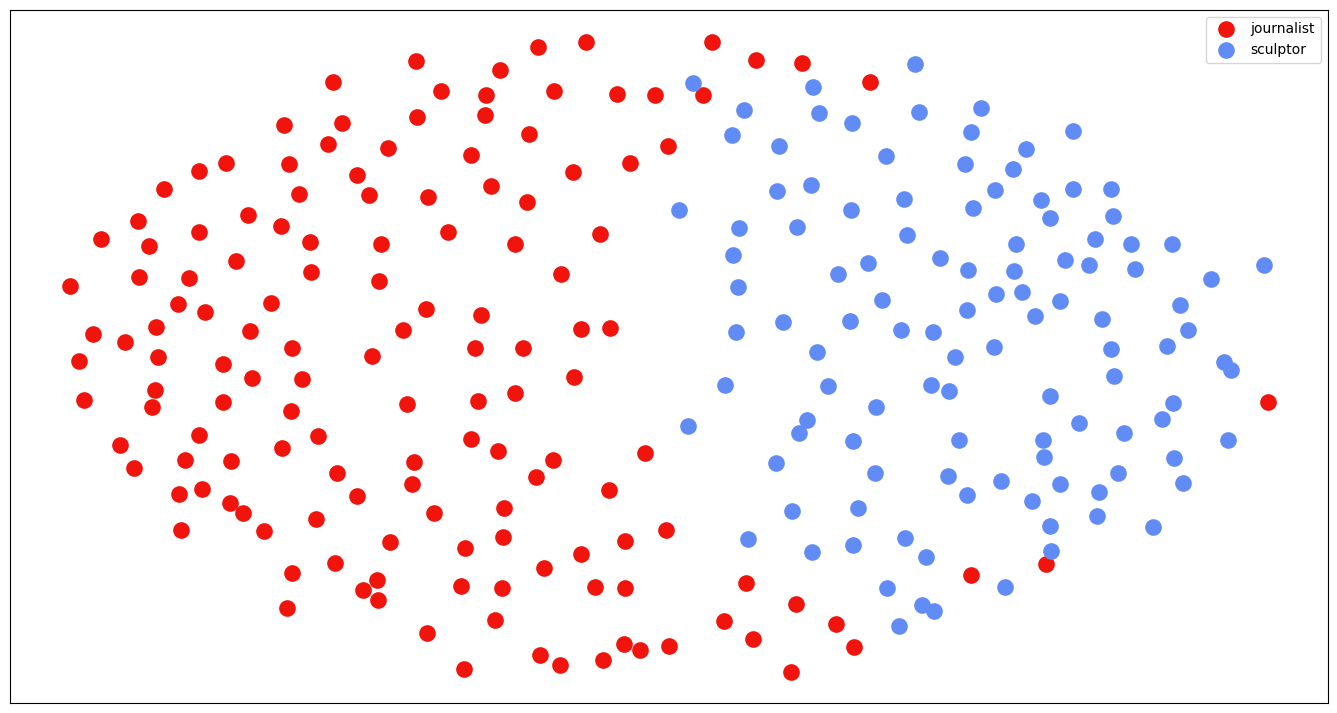

In [57]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], 
            color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
    
ax.legend(numpoints=1)  #show legend with only 1 point
    
    
plt.show() #show the plot


## MAIN #####################################################################################

In [5]:
def main():
    print(createBiographyDataFrames())
    #print('hello')
    

In [6]:
if __name__=='__main__':
    main()

Unexpected err=IndexError('list index out of range'), type(err)=<class 'IndexError'>, could not process Margaret Trowell


c:\Users\Etudiant\M1_TAL\m1-datascience-project\.venv\Lib\site-packages\SPARQLWrapper\Wrapper.py:794: RuntimeWarning: Sending Accept header '*/*' because unexpected returned format 'json' in a 'DESCRIBE' SPARQL query form
  warnings.warn(


Sculptors George Lilanga processed
Sculptors Eric Gill works at the Midland Hotel, Morecambe processed
Sculptors New British Sculpture processed
Sculptors New Sculpture processed
Sculptors Orestes Acquarone processed
Sculptors Georges Adéagbo processed
Sculptors Kudjoe Affutu processed
Sculptors Julio Aguilera processed
Sculptors Adebisi Akanji processed
Sculptors Kwame Akoto-Bamfo processed
Sculptors Sunday Jack Akpan processed
Sculptors Enrique Alférez processed
Sculptors José Simões de Almeida processed
Sculptors Julio Alpuy processed
Sculptors Maximiano Alves processed
Sculptors Eric Adjetey Anang processed
Sculptors El Anatsui processed
Sculptors Mark Antokolsky processed
Sculptors Massoud Arabshahi processed
Sculptors Carmelo Arden Quin processed
Sculptors Pablo Atchugarry processed
Sculptors Kevin Atherton processed
Sculptors Armando de Basto processed
Sculptors Alberto Bautista Gómez processed
Sculptors José Belloni processed
Sculptors Stelio Belloni processed
Sculptors Ahron B